# Question 1

we want to check if race matter for our models.

In [14]:
import os
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import joblib 
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import sys
import math

project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.append(project_root)
    
import img2vec

### Read the data

In [3]:
data_dir = os.path.join('..' , 'data')
models_dir = os.path.join('..', 'models')
data = pd.read_csv(os.path.join(data_dir, 'UTKFace.csv'))

### aadd path to the images

In [4]:
def construct_img_path(row):
    return os.path.join('..', 'data', 'UTKFace', row['image'])

data['img_path'] = data.apply(construct_img_path, axis=1)

### add age gender lable

In [5]:
data['age_gender'] = data['age'].astype(str) + '_' + data['gender'].astype(str)
encoder = joblib.load(os.path.join(models_dir, 'combined_encoder.pkl'))
data['encoded_label'] = encoder.transform(data['age_gender'])


In [6]:
race_names = {0: 'White', 1: 'Black', 2: 'Asian', 3: 'Indian', 4: 'Others'}

### create a chart distribution of the races 

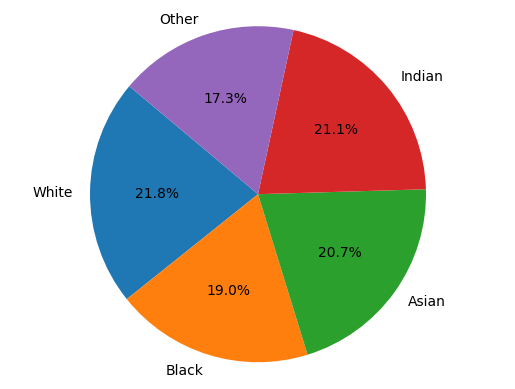

In [7]:
lables = ['White', 'Black', 'Asian', 'Indian', 'Other']
sizes = [data[data['race'] == label_index].shape[0] for label_index, label in enumerate(lables)]
plt.pie(sizes, labels=lables, autopct='%1.1f%%', startangle=140)
plt.axis('equal')
plt.show()

### plot age and gender distribution for each race 

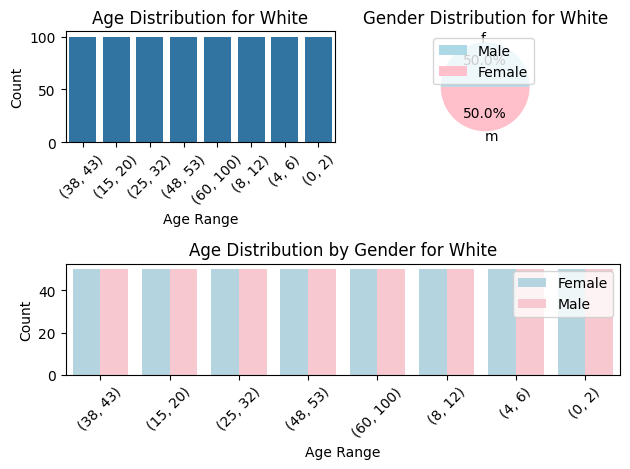

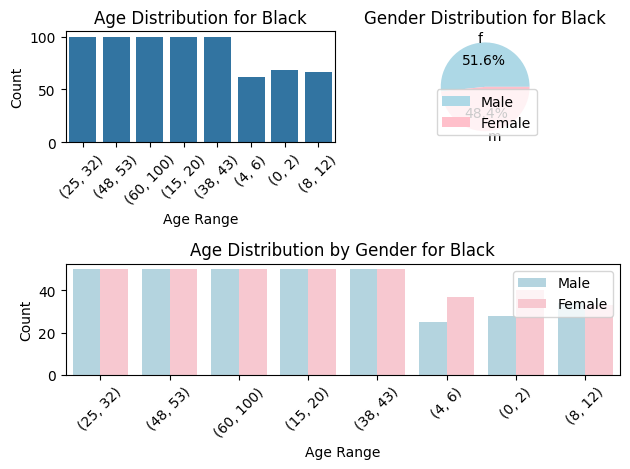

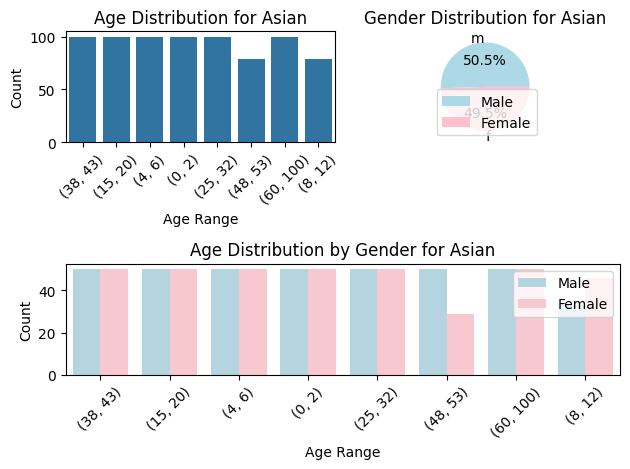

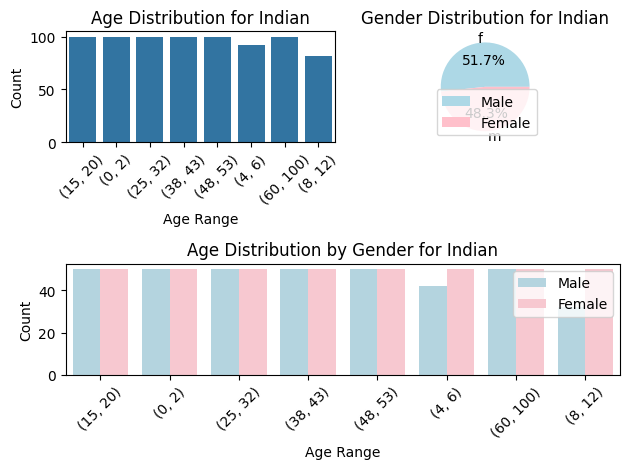

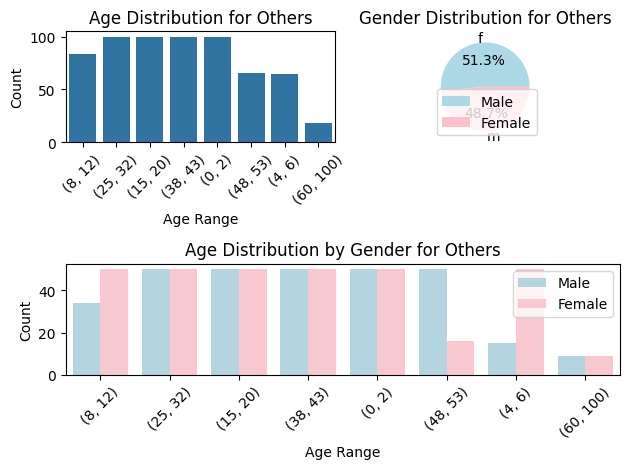

In [8]:
def plot_age_gender_distribution_for_race(race_index:int):
    race_data = data[data['race'] == race_index]
    race_name = race_names.get(race_index)
    plt.subplot(2, 2, 1)
    sns.countplot(x='age', data=race_data)
    plt.title(f'Age Distribution for {race_name}')
    plt.xlabel('Age Range')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    
    # Plot 2: Gender distribution
    plt.subplot(2, 2, 2)
    gender_counts = race_data['gender'].value_counts()
    plt.pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%', colors=['lightblue', 'pink'])
    plt.title(f'Gender Distribution for {race_name}')
    plt.legend(['Male', 'Female'] if 'm' in gender_counts.index else ['Female', 'Male'])
    
    # Plot 3: Age distribution by gender
    plt.subplot(2, 1, 2)
    sns.countplot(x='age', hue='gender', data=race_data, palette=['lightblue', 'pink'])
    plt.title(f'Age Distribution by Gender for {race_name}')
    plt.xlabel('Age Range')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.legend(['Male', 'Female'] if 'm' in race_data['gender'].unique()[0] else ['Female', 'Male'])
    
    plt.tight_layout()
    plt.show()

for i in range(5):
    plot_age_gender_distribution_for_race(i)

## load the models

In [9]:
rgb_scaler = joblib.load(os.path.join(models_dir, 'combined_scaler.pkl'))
gray_scaler = joblib.load(os.path.join(models_dir, 'combined_scaler_gray.pkl'))

kerse_models_rgb = {
    'mlp': tf.keras.models.load_model(os.path.join(models_dir, 'mlp_model_rgb.h5')),
}

kerse_models_gray = {
    'mlp': tf.keras.models.load_model(os.path.join(models_dir, 'mlp_model_grayscale.h5')),
}

cnn_models_rgb = {
    'cnn': tf.keras.models.load_model(os.path.join(models_dir, 'cnn_model_rgb.h5')),
}

cnn_models_gray = {
    'cnn': tf.keras.models.load_model(os.path.join(models_dir, 'cnn_model_grayscale.h5')),
}

sklearn_models_rgb = {
    'adaboost': joblib.load(os.path.join(models_dir, 'adaboost_model_rgb.pkl')),
    'knn': joblib.load(os.path.join(models_dir, 'knn9_model_rgb.pkl')),
    'random_forest': joblib.load(os.path.join(models_dir, 'rf_model_rgb.pkl')),
    'softmax': joblib.load(os.path.join(models_dir, 'softmax_model_rgb.pkl')),
    'svm': joblib.load(os.path.join(models_dir, 'svm_model_rgb.pkl')),
}

sklearn_models_gray = {
    'adaboost': joblib.load(os.path.join(models_dir, 'adaboost_model_grayscale.pkl')),
    'knn': joblib.load(os.path.join(models_dir, 'knn9_model_grayscale.pkl')),
    'random_forest': joblib.load(os.path.join(models_dir, 'rf_model_grayscale.pkl')),
    'softmax': joblib.load(os.path.join(models_dir, 'softmax_model_grayscale.pkl')),
    'svm': joblib.load(os.path.join(models_dir, 'svm_model_grayscale.pkl')),
}

In [10]:
def predict_kerser_model(model, image_path: str, emb_function, scaler):
    features = emb_function([image_path])
    features_scaled = scaler.transform(features)
    probs = model.predict(features_scaled)[0]
    predicted_class_idx = np.argmax(probs)
    confidence = float(probs[predicted_class_idx])
    predicted_class = encoder.classes_[predicted_class_idx]
    age, gender = predicted_class.split("_")
    return {
        "age": age,
        "gender": gender,
        "confidence": confidence,
        "class_index": int(predicted_class_idx),
    }


def predict_kerser_rgb_model(model_name: str, image_path: str):
    return predict_kerser_model(kerse_models_rgb.get(model_name), image_path, img2vec.rgb2emb, rgb_scaler)


def predict_kerser_gray_model(model_name: str, image_path: str):
    return predict_kerser_model(kerse_models_gray.get(model_name), image_path, img2vec.gray2emb , gray_scaler)


def predict_sklearn_model(model, image_path: str, emb_function, scaler):
    features = emb_function([image_path])
    features_scaled = scaler.transform(features)
    predicted_class_idx = model.predict(features_scaled)[0]

    # Get confidence (probability)
    if hasattr(model, "predict_proba"):
        probs = model.predict_proba(features_scaled)[0]
        confidence = float(probs[predicted_class_idx])
    else:
        # For models without probability estimates
        confidence = None

    predicted_class = encoder.classes_[predicted_class_idx]
    age, gender = predicted_class.split("_")
    return {
        "age": age,
        "gender": gender,
        "confidence": confidence,
        "class_index": int(predicted_class_idx),
    }


def predict_sklearn_rgb_model(model_name: str, image_path: str):
    return predict_sklearn_model(sklearn_models_rgb.get(model_name), image_path, img2vec.rgb2emb, rgb_scaler)


def predict_sklearn_gray_model(model_name: str, image_path: str):
    return predict_sklearn_model(sklearn_models_gray.get(model_name), image_path, img2vec.gray2emb, gray_scaler)


def predict_cnn_model(model_name: str, image_path: str):
    model = cnn_models_rgb.get(model_name)
    img = image.load_img(image_path, target_size=(128, 128))  # Use 128x128 for CNN
    img_array = image.img_to_array(img)
    img_array = img_array / 255.0  # Rescale to [0,1]
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Make prediction with CNN model
    probs = model.predict(img_array)[0]
    predicted_class_idx = np.argmax(probs)
    confidence = float(probs[predicted_class_idx])

    predicted_class = encoder.classes_[predicted_class_idx]
    age, gender = predicted_class.split("_")
    return {
        "age": age,
        "gender": gender,
        "confidence": confidence,
        "class_index": int(predicted_class_idx),
    }

In [11]:
def preprocess_features(image_paths, output_file, batch_size=64):
    if os.path.exists(output_file):
        print(f"Loading pre-processed features from {output_file}")
        return np.load(output_file)

    print(f"Processing {len(image_paths)} images and saving to {output_file}")
    all_features = []

    for i in range(0, len(image_paths), batch_size):
        batch_paths = image_paths[i:i + batch_size]
        print(f"Processing batch {i // batch_size + 1}/{math.ceil(len(image_paths) / batch_size)}")
        batch_features = img2vec.rgb2emb(batch_paths)
        all_features.append(batch_features)

    all_features = np.vstack(all_features)
    np.save(output_file, all_features)
    return all_features

In [12]:
white_data = data[data['race'] == 0]
black_data = data[data['race'] == 1]
asian_data = data[data['race'] == 2]
indian_data = data[data['race'] == 3]
other_data = data[data['race'] == 4]

#check if the features are already preprocessed
if os.path.exists(os.path.join(data_dir, 'white_features.npy')):
    white_features = np.load(os.path.join(data_dir, 'white_features.npy'))
    black_features = np.load(os.path.join(data_dir, 'black_features.npy'))
    asian_features = np.load(os.path.join(data_dir, 'asian_features.npy'))
    indian_features = np.load(os.path.join(data_dir, 'indian_features.npy'))
    other_features = np.load(os.path.join(data_dir, 'other_features.npy'))
else:
    white_features = rgb_scaler.transform(preprocess_features(white_data['img_path'].tolist(), os.path.join(data_dir, 'white_features.npy')))
    black_features = rgb_scaler.transform(preprocess_features(black_data['img_path'].tolist(), os.path.join(data_dir, 'black_features.npy')))
    asian_features = rgb_scaler.transform(preprocess_features(asian_data['img_path'].tolist(), os.path.join(data_dir, 'asian_features.npy')))
    indian_features = rgb_scaler.transform(preprocess_features(indian_data['img_path'].tolist(), os.path.join(data_dir, 'indian_features.npy')))
    other_features = rgb_scaler.transform(preprocess_features(other_data['img_path'].tolist(), os.path.join(data_dir, 'other_features.npy')))


    np.save(os.path.join(data_dir, 'white_features.npy'), white_features)
    np.save(os.path.join(data_dir, 'black_features.npy'), black_features)
    np.save(os.path.join(data_dir, 'asian_features.npy'), asian_features)
    np.save(os.path.join(data_dir, 'indian_features.npy'), indian_features)
    np.save(os.path.join(data_dir, 'other_features.npy'), other_features)

### create image data generator for the cnn models

In [15]:
white_datagen = ImageDataGenerator(rescale=1./255)
black_datagen = ImageDataGenerator(rescale=1./255)
asian_datagen = ImageDataGenerator(rescale=1./255)
indian_datagen = ImageDataGenerator(rescale=1./255)
other_datagen = ImageDataGenerator(rescale=1./255)

white_generator = white_datagen.flow_from_dataframe(
    white_data,
    x_col='img_path',
    y_col='encoded_label',
    target_size=(128, 128),
    batch_size=64,
    class_mode='raw',
    shuffle=False,
)

black_generator = black_datagen.flow_from_dataframe(
    black_data,
    x_col='img_path',
    y_col='encoded_label',
    target_size=(128, 128),
    batch_size=64,
    class_mode='raw',
    shuffle=False,
)

asian_generator = asian_datagen.flow_from_dataframe(
    asian_data,
    x_col='img_path',
    y_col='encoded_label',
    target_size=(128, 128),
    batch_size=64,
    class_mode='raw',
    shuffle=False,
)

indian_generator = indian_datagen.flow_from_dataframe(
    indian_data,
    x_col='img_path',
    y_col='encoded_label',
    target_size=(128, 128),
    batch_size=64,
    class_mode='raw',
    shuffle=False,
)

other_generator = other_datagen.flow_from_dataframe(
    other_data,
    x_col='img_path',
    y_col='encoded_label',
    target_size=(128, 128),
    batch_size=64,
    class_mode='raw',
    shuffle=False,
)

Found 800 validated image filenames.
Found 697 validated image filenames.
Found 758 validated image filenames.
Found 774 validated image filenames.
Found 633 validated image filenames.


## Test the models on diffrents races

In [17]:
for model_name, model in cnn_models_rgb.items():
    print(f"Accuracy for {model_name} model:")
    white_predictions = model.evaluate(white_generator)
    black_predictions = model.evaluate(black_generator)
    asian_predictions = model.evaluate(asian_generator)
    indian_predictions = model.evaluate(indian_generator)
    other_predictions = model.evaluate(other_generator)

    print(f"White: {white_predictions[1]:.2f}")
    print(f"Black: {black_predictions[1]:.2f}")
    print(f"Asian: {asian_predictions[1]:.2f}")
    print(f"Indian: {indian_predictions[1]:.2f}")
    print(f"Other: {other_predictions[1]:.2f}")
    print()

for model_name, model in sklearn_models_rgb.items():
    print(f"Accuracy for {model_name} model:")
    white_predictions = model.predict(white_features)
    black_predictions = model.predict(black_features)
    asian_predictions = model.predict(asian_features)
    indian_predictions = model.predict(indian_features)
    other_predictions = model.predict(other_features)

    white_accuracy = np.mean(white_predictions == white_data['encoded_label'])
    black_accuracy = np.mean(black_predictions == black_data['encoded_label'])
    asian_accuracy = np.mean(asian_predictions == asian_data['encoded_label'])
    indian_accuracy = np.mean(indian_predictions == indian_data['encoded_label'])
    other_accuracy = np.mean(other_predictions == other_data['encoded_label'])

    print(f"White: {white_accuracy:.2f}")
    print(f"Black: {black_accuracy:.2f}")
    print(f"Asian: {asian_accuracy:.2f}")
    print(f"Indian: {indian_accuracy:.2f}")
    print(f"Other: {other_accuracy:.2f}")
    print()

for model_name, model in kerse_models_rgb.items():
    print(f"Accuracy for {model_name} model:")
    white_predictions = model.predict(white_features)
    black_predictions = model.predict(black_features)
    asian_predictions = model.predict(asian_features)
    indian_predictions = model.predict(indian_features)
    other_predictions = model.predict(other_features)

    # Convert probability distributions to class predictions
    white_preds_class = np.argmax(white_predictions, axis=1)
    black_preds_class = np.argmax(black_predictions, axis=1)
    asian_preds_class = np.argmax(asian_predictions, axis=1)
    indian_preds_class = np.argmax(indian_predictions, axis=1)
    other_preds_class = np.argmax(other_predictions, axis=1)

    white_accuracy = np.mean(white_preds_class == white_data['encoded_label'])
    black_accuracy = np.mean(black_preds_class == black_data['encoded_label'])
    asian_accuracy = np.mean(asian_preds_class == asian_data['encoded_label'])
    indian_accuracy = np.mean(indian_preds_class == indian_data['encoded_label'])
    other_accuracy = np.mean(other_preds_class == other_data['encoded_label'])

    print(f"White: {white_accuracy:.2f}")
    print(f"Black: {black_accuracy:.2f}")
    print(f"Asian: {asian_accuracy:.2f}")
    print(f"Indian: {indian_accuracy:.2f}")
    print(f"Other: {other_accuracy:.2f}")
    print()

Accuracy for cnn model:


c:\Users\shayg\projects\ML\final_project\venv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


13/13 ━━━━━━━━━━━━━━━━━━━━ 11s 870ms/step - accuracy: 0.1814 - loss: 2.5094
11/11 ━━━━━━━━━━━━━━━━━━━━ 9s 920ms/step - accuracy: 0.1489 - loss: 2.5593
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 926ms/step - accuracy: 0.2492 - loss: 2.2377
13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 841ms/step - accuracy: 0.1922 - loss: 2.4941
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 926ms/step - accuracy: 0.2803 - loss: 2.2096
White: 0.17
Black: 0.11
Asian: 0.17
Indian: 0.14
Other: 0.22

Accuracy for adaboost model:
White: 0.18
Black: 0.13
Asian: 0.17
Indian: 0.15
Other: 0.20

Accuracy for knn model:
White: 0.17
Black: 0.15
Asian: 0.19
Indian: 0.14
Other: 0.17

Accuracy for random_forest model:
White: 0.19
Black: 0.17
Asian: 0.20
Indian: 0.17
Other: 0.23

Accuracy for softmax model:
White: 0.23
Black: 0.18
Asian: 0.25
Indian: 0.22
Other: 0.23

Accuracy for svm model:
White: 0.07
Black: 0.07
Asian: 0.07
Indian: 0.06
Other: 0.08

Accuracy for mlp model:
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
24/24 ━━